In [2]:
%pip install pandas
%pip install scipy
import matplotlib.pyplot as plt
import numpy as np
import yt
import matplotlib.cm as cm
from plot_variables import *
from yt.utilities.math_utils import ortho_find



Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [14]:
from helper_functions import *
import datetime
import pandas as pd
from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm
from scipy.interpolate import interp1d
import matplotlib.image as mpimg


In [4]:
ds = yt.load("/disk14/sgordon/pleiades-11-12-23/seed1-bh-only/270msun/thermal-fb/1B.th.bf128/DD0600/DD0600")

yt : [INFO     ] 2024-06-13 09:38:42,162 Parameters: current_time              = 13.984875219842
yt : [INFO     ] 2024-06-13 09:38:42,163 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-06-13 09:38:42,165 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-06-13 09:38:42,184 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-06-13 09:38:42,185 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-06-13 09:38:42,187 Parameters: current_redshift          = 26.240077770767
yt : [INFO     ] 2024-06-13 09:38:42,188 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2024-06-13 09:38:42,188 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2024-06-13 09:38:42,190 Parameters: omega_radiation           = 0
yt : [INFO     ] 2024-06-13 09:38:42,191 Parameters: hubble_constant           = 0.71


In [5]:
data_files = ['data_files/data-1B.RSb01-2.csv', 
              #'data_files/data-2B.RSb01.csv',
              'data_files/data-1B.resim.th.b01.csv']

def extract_filename_parts(file_paths):
    extracted_parts = []
    for path in file_paths:
        # Extract the base name of the file (e.g., 'data-1B.resim.th.b01-3-eta-0.1.csv')
        base_name = os.path.basename(path)
        # Remove the prefix 'data-' and the file extension '.csv'
        clean_name = base_name.replace('data-', '').rsplit('.', 1)[0]
        extracted_parts.append(clean_name)
    return extracted_parts

label = extract_simulation_name_from_csv(data_files[1])
label

'1B.resim.th.b01'

#### Helper functions

In [6]:
def setup_plot_env(fontsize, linewidth):
    rc('font', **{'family': 'serif', 'serif': ['Times'], 'weight': 'light'})
    rc('text', usetex=True)
    plt.rcParams["mathtext.default"] = "regular"
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['lines.linewidth'] = linewidth


# Function to format and create the subplots
def create_subplots(num_subplots, xlim, ylim_mass, time_cutoff, fontsize, title):
    fig, axs = plt.subplots(num_subplots, 1, sharex=True)

    for i in range(num_subplots):
        axs[i].set_xticks(np.arange(0.1, time_cutoff+0.1, 0.1))
        axs[i].minorticks_on()
        axs[i].xaxis.set_minor_locator(plt.MultipleLocator(0.02))
        axs[i].tick_params(axis="x", which='minor', length=2, direction="in")
        axs[i].tick_params(axis="x", which='major', labelsize=fontsize-1, width=1.5, length=3, direction="in")
        axs[i].tick_params(axis="y", which='major', labelsize=fontsize-1)
        axs[i].tick_params(axis="y", which='minor', labelsize=fontsize-2)
        axs[i].set_yscale('log')
        axs[i].set_xlim([0, xlim+0.01]) # for truncated view

    axs[0].set_title(title)
    #axs[0].set_ylim([10.5, ylim_mass+0.01]) # for truncated view 270msun: [240, ylim_mass+0.01]
    axs[0].set_ylabel(r"$\rm M_{BH} \, (M_{\odot})$", fontdict=None)
    axs[1].set_ylabel(r"$\rm \dot{M} \, (M_{\odot}/yr)$", fontdict=None)
    #axs[1].set_ylim([2e-9, 8e-4]) # [2e-9, 8e-4] for 270msun, [5e-9, 6e-2] for 10.8msun-no-SN, [2e-9, 8e-4] for 10.8msun
    axs[-1].set_xlabel('Black Hole Age (Myr)', fontdict=None)

    return fig, axs

def dynamical_timescale_ff(rho):
    # rho in g/cm^3
    return np.sqrt(3*np.pi/(32*6.67e-8*rho))

def dynamical_timescale_vel(v_orb, r):
    # v in cm/s, r in cm
    return 2*np.pi*r/v_orb

def temperature_from_cs(df):
    kb = 1.38e-16 # Boltzmann in erg/K
    mu = 1.3 # mean molecular weight
    gamma = 1.6667
    cs2 = [i*i for i in df['average cinfinity'].dropna().values]
    temp = cs2*mu/(kb*gamma)
    return temp

def sound_crossing_timescale(df, window_size=10, type='jeans'):
    pc_to_km = 3.086e13
    s_to_myr = 1/3.154e13
    scale_df = df['Jeans length'].replace(0, pd.NA).dropna() if type == 'jeans' else df['Bondi radius'].replace(0, pd.NA).dropna()
    cs_df = df['average cinfinity'].replace(0, pd.NA).dropna()
    print(scale_df.shape, cs_df.shape)
    if scale_df.shape != cs_df.shape:
        print('Lengths do not match')
        return
    return (scale_df*pc_to_km/cs_df)*s_to_myr


In [7]:
# Set up plot environment
fontsize = 12
linewidth = 2
alpha = 1
window_size = 100
setup_plot_env(fontsize, linewidth)
num_subplots = 4
#title = '270msun resimulated from 31.7 Myr with thermal feedback'
title = '270msun with thermal feedback (no stellar phase)'

# Load the CSV file into a DataFrame
data_files = [#'data_files/data-1B.RSb04.csv', 
              #'data_files/data-2B.RSb01.csv',
              #'data_files/data-1B.resim.th.b01.csv'
    'data_files/data-1B.resim.th.b01-3-eta-0.1.csv',
    'data_files/data-1B.resim.th.b01-3-eta-0.01.csv',
    'data_files/data-1B.resim.th.b01-3-eps-0.001.csv',
    'data_files/data-1B.resim.th.b01-3-eps-0.0001.csv',
    'data_files/data-1B.RSb01-2.csv'
    # 'data_files/data-1B.RSb01-2.csv',
    # 'data_files/data-1B.th.bf128.csv',
    # 'data_files/data-1B.th.bf128-eps-0.01.csv',
    # 'data_files/data-1B.th.bf128-eps-0.0001.csv',
    ]

# Line colours
c = extract_colors('arbre', int(len(data_files)), start=0.1, end=0.86) # start=0.33, end=0.92 for 10.8msun-no-sn
#c_s2 = extract_colors('magma', int(len(data_files)/2), portion="middle", start=0.4, end=0.85) # start=0.3, end=0.85 for 10.8msun-no-sn
#c = np.concatenate((c_s1, c_s2))

# Data labels
labels = extract_filename_parts(data_files)
#labels = ['no-fb', r"$\rm \eta=0.1$, $\epsilon=0.05$", r"$\times 0.1$", r"$\times 0.05$", r"$\times 0.005$"]
#labels = ["no-fb", r"$\rm \eta=0.1, \epsilon=0.05$", r"$\epsilon=0.01$", r"$\epsilon=0.0001$"]

# Define rho for the dynamical timescale
rho_index = 1
df = pd.read_csv(data_files[rho_index]).dropna()
rho = df['average density'].values.mean()
t_cs = sound_crossing_timescale(df, window_size, type='bondi')
print(f"density = {rho:.0e}")

# find the dynamical timescale 
mh = 1.6735e-24 # hydrogen mass in g
t_ff = dynamical_timescale_ff(rho*mh)/3.15576e13

(2986,) (2986,)
density = 2e+06


## BH/Gas properties vs Time for Feedback Runs

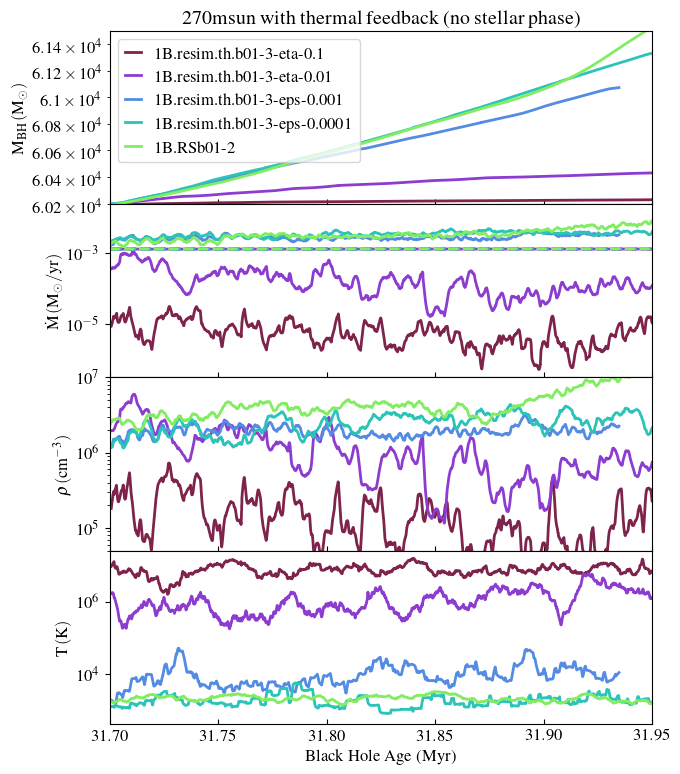

In [8]:

fig, axs = plt.subplots(num_subplots, 1)
window_size = 100
age_units = None # or "t_cs" or None
for j, data_file in enumerate(data_files):

    # Load the CSV file into a DataFrame
    df = pd.read_csv(data_file)

    # Extract the columns you're interested in
    #age = df['age'].values/1e6
    age = (df['age'].values/1e6)/t_cs.mean() if age_units == "t_cs" else (df['age'].values/1e6)/t_ff if age_units == "t_ff" else df['age'].values/1e6
    bh_mass = adaptive_moving_average(df['BH mass'].values, window_size)
    accrate = adaptive_moving_average(df['accrate'].values, window_size)
    density = adaptive_moving_average(df['average density'].values, window_size)
    temperature = adaptive_moving_average(df['temperature'].values, window_size)

    # 1) BH Mass
    axs[0].plot(age, bh_mass, color=c[j], linestyle='solid', label=labels[j], alpha=alpha)

    # 2) Accretion Rates
    axs[1].plot(age, accrate, color=c[j], linestyle='solid', label=labels[j], alpha=alpha)
    axs[1].plot(age, eddington_rate(bh_mass), color=c[j], linestyle='dashed', label=labels[j], alpha=alpha)

    # 3) Density
    axs[2].plot(age, density, color=c[j], linestyle='solid', label=labels[j], alpha=alpha)

    # 3) Temperature
    axs[3].plot(age, temperature, color=c[j], linestyle='solid', label=labels[j], alpha=alpha) #if j != 0 else None


# Force x-axis ticks to appear on all subplots
for i, ax in enumerate(axs):
    ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, direction="in")
    ax.set_xlim([31.70, 31.95]) # set xlim
    ax.set_xticklabels([]) if i < 3 else None

# Set y-axis limits
axs[0].set_yscale('log')
axs[1].set_yscale('log')
axs[2].set_yscale('log')
axs[3].set_yscale('log')
axs[0].set_ylim([6.02e4, 6.15e4])
axs[2].set_ylim([5e4, 1e7])

# Set labels
axs[0].set_ylabel(r"$\rm M_{BH} \, (M_{\odot})$", fontdict=None)
axs[1].set_ylabel(r"$\rm \dot{M} \, (M_{\odot}/yr)$", fontdict=None)
axs[2].set_ylabel(r"$\rm \rho \, (cm^{-3})$", fontdict=None)
axs[3].set_ylabel(r"$\rm T \, (K)$", fontdict=None)
if age_units == "t_cs":
    axs[-1].set_xlabel(r'$t_{{c_s}} (t_{{c_s}} = {:.0e}$ Myr, line \ {})'.format(t_cs.mean(), rho_index+1), fontdict=None)
elif age_units == "t_ff":
    axs[-1].set_xlabel(r'$t_{{ff}} (\rho = {:.0e}, line \ {})$'.format(rho, rho_index+1), fontdict=None)
else:
    axs[-1].set_xlabel('Black Hole Age (Myr)', fontdict=None)

# legend and title
axs[0].legend(fontsize=fontsize, ncol=1, loc="upper left", handlelength=1) # "lower right" for no-sn
axs[0].set_title(title)
fig.subplots_adjust(wspace=0, hspace=0)
fig.set_size_inches(7, 9)

In [25]:
timestamp = datetime.datetime.now().strftime("%Y-%m-%d")
figname = title.replace(' ', '_').replace('(', '').replace(')', '') + f"_{timestamp}"
plt.savefig(f'plots/{figname}.png', dpi=300, bbox_inches='tight')
print(f"Saved plot to plots/{figname}.png")

Saved plot to plots/270msun_with_thermal_feedback_no_stellar_phase_2024-06-12.png


<Figure size 640x480 with 0 Axes>

(3035,) (3035,)
(3035,) (3035,)
(2986,) (2986,)
(2986,) (2986,)
(2343,) (2343,)
(2343,) (2343,)
(2622,) (2622,)
(2622,) (2622,)
(507811,) (507811,)
(507811,) (507811,)


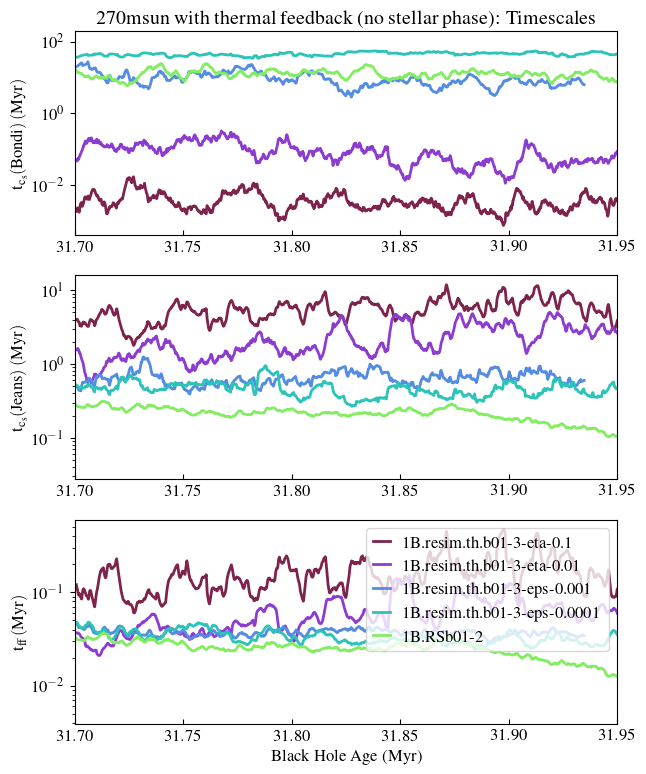

In [10]:
# timescales plot
fig, axs = plt.subplots(3, 1, sharex=True)
window_size = 100
age_units = None # or "t_cs" or None
for j, data_file in enumerate(data_files):

    # Load the CSV file into a DataFrame
    df = pd.read_csv(data_file)

    # sound crossing timescale Bondi
    t_cs = adaptive_moving_average(sound_crossing_timescale(df, window_size, type='bondi'), window_size)

    # # sound crossing timescale Jeans
    t_jeans = adaptive_moving_average(sound_crossing_timescale(df, window_size, type='jeans'), window_size)

    # # find the dynamical timescale 
    mh = 1.6735e-24 # hydrogen mass in g
    density = adaptive_moving_average(df['average density'].values, window_size)
    t_ff = dynamical_timescale_ff(density*mh)/3.15576e13

    # Assuming df['age'].values and t_cs are available and sorted
    x_original = np.linspace(0, 1, len(df['age'].values))  # Normalize original x-axis
    x_new = np.linspace(0, 1, len(t_cs))  # New x-axis for interpolation

    # Create interpolation function
    interp_func = interp1d(x_original, df['age'].values/1e6)

    # Interpolate 'age' to match 't_cs' length
    age_interpolated = interp_func(x_new)

    # plot the timescales
    axs[0].plot(adaptive_moving_average(age_interpolated, int(len(df['age'].values)/len(t_cs))), t_cs, color=c[j], linestyle='solid', label=labels[j], alpha=alpha)
    axs[1].plot(adaptive_moving_average(age_interpolated, int(len(df['age'].values)/len(t_jeans))), t_jeans, color=c[j], linestyle='solid', label=labels[j], alpha=alpha)
    axs[2].plot(df['age'].values/1e6, t_ff, color=c[j], linestyle='solid', label=labels[j], alpha=alpha)

# Force x-axis ticks to appear on all subplots
for i, ax in enumerate(axs):
    ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, direction="in")
    if i != (num_subplots - 1): ax.set_label('')

# Set labels
for i in range(3):
    axs[i].set_yscale('log')

# set axes labels
axs[0].set_ylabel(r"$\rm t_{c_s} (Bondi) \, (Myr)$", fontdict=None)
axs[1].set_ylabel(r"$\rm t_{c_s} (Jeans) \, (Myr)$", fontdict=None)
axs[2].set_ylabel(r"$\rm t_{ff} \, (Myr)$", fontdict=None)
axs[-1].legend(fontsize=fontsize, ncol=1, loc="upper right", handlelength=1) 
axs[-1].set_xlabel('Black Hole Age (Myr)', fontdict=None)


# Set axes limits
#axs[0].set_ylim([2e-5, 2])
axs[-1].set_xlim([31.70, 31.95]) # for truncated view
#axs[-1].set_xlim([0, 1.4])
#axs[1].set_ylim([2e-6, 2e-1]) # 
axs[0].set_title('270msun with thermal feedback (no stellar phase): Timescales')
fig.set_size_inches(7, 9)


# Making (1, 3) panel

In [12]:
def extract_parts(fp):
    # Define the regex pattern to capture the desired parts
    # This pattern looks for a string between the second and third underscore
    # and a DD0 followed by digits
    pattern = r'.*?_([^_]+)_(DD0\d+)_.*'

    # Search using the pattern
    match = re.search(pattern, fp)
    
    # If a match is found, return the captured groups; otherwise return None for both
    if match:
        part1, part2 = match.groups()
        return part1, part2
    else:
        return None, None
    


def make_3_panel_plot(image_paths):
    # Extract the simulation and DD number from the first image path
    sim, dd = extract_parts(image_paths[0]) 

    # Create a figure and a set of subplots
    fig, axs = plt.subplots(1, 3, figsize=(10, 3.333))

    # Loop through the image paths and axs to display each image
    for ax, image_path in zip(axs, image_paths):
        img = mpimg.imread(image_path)  # Load the image
        ax.imshow(img)  # Display the image
        ax.axis('off')  # Turn off axis
    # Manually adjust the positions of the first two subplots to make them overlap
    # ax.set_position([left, bottom, width, height]) where the values are fraction of figure width and height
    axs[0].set_position([0.0, 0.1, 0.4, 0.8])  # Example position for the first subplot
    axs[1].set_position([0.265, 0.1, 0.4, 0.8])  # Adjust so the second subplot overlaps the first
    axs[2].set_position([0.265*2, 0.1, 0.4, 0.8])
    axs[1].set_title('Clumps in {sim} at {dd}'.format(sim=sim, dd=dd))  # Add a title to the figure
    plt.savefig(f'clump_projection_{sim}_{dd}_grav_bound_combined.png')  # Save the combined image to a file
    plt.show()  # Display the figure
    #print(f'Combined image saved as clump_projection_{sim}_{dd}_grav_bound_combined.png')  # Print a message to the console


# 1B.b01

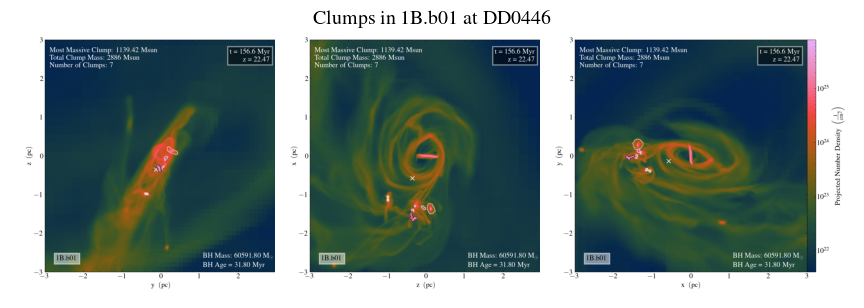

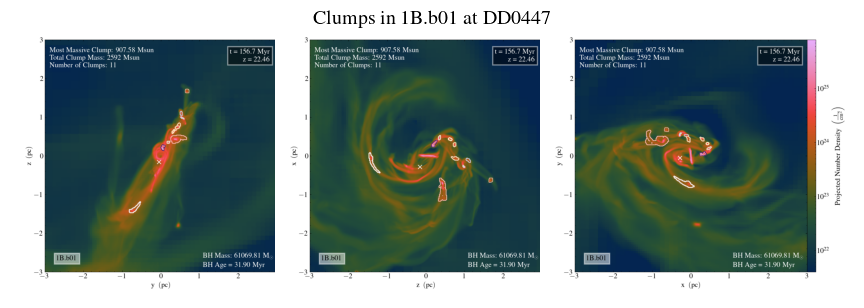

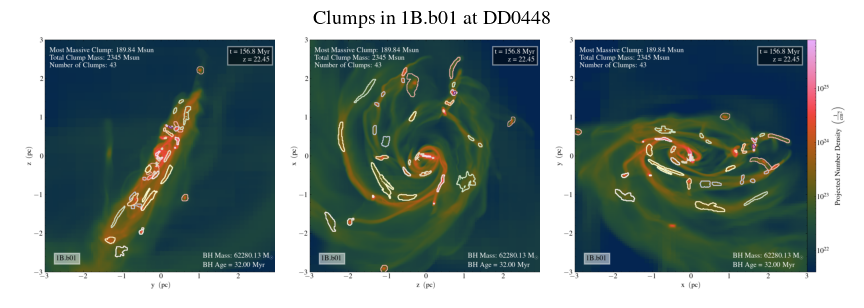

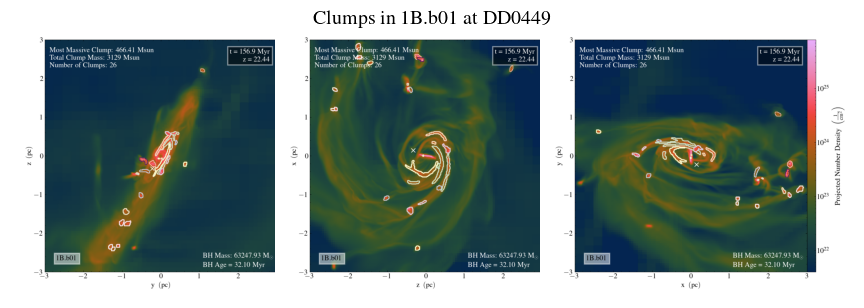

In [15]:
# Paths to your PNG images
image_paths_1 = ['../plots/clump_projection_1B.b01_DD0446_0_8.70e+05_grav_bound.png', 
               '../plots/clump_projection_1B.b01_DD0446_1_8.70e+05_grav_bound.png', 
               '../plots/clump_projection_1B.b01_DD0446_2_8.70e+05_grav_bound.png']
image_paths_2 = ['../plots/clump_projection_1B.b01_DD0447_0_7.51e+05_grav_bound.png', 
               '../plots/clump_projection_1B.b01_DD0447_1_7.51e+05_grav_bound.png', 
               '../plots/clump_projection_1B.b01_DD0447_2_7.51e+05_grav_bound.png']
image_paths_3 = ['../plots/clump_projection_1B.b01_DD0448_0_1.05e+05.png', 
               '../plots/clump_projection_1B.b01_DD0448_1_1.05e+05.png', 
               '../plots/clump_projection_1B.b01_DD0448_2_1.05e+05.png']
image_paths_4 = ['../plots/clump_projection_1B.b01_DD0449_0_1.28e+06.png',
                 '../plots/clump_projection_1B.b01_DD0449_1_1.28e+06.png',
                 '../plots/clump_projection_1B.b01_DD0449_2_1.28e+06.png']
make_3_panel_plot(image_paths_1)
make_3_panel_plot(image_paths_2)
make_3_panel_plot(image_paths_3)
make_3_panel_plot(image_paths_4)

# 1B.resim.th.b01-3-eps-0.0001

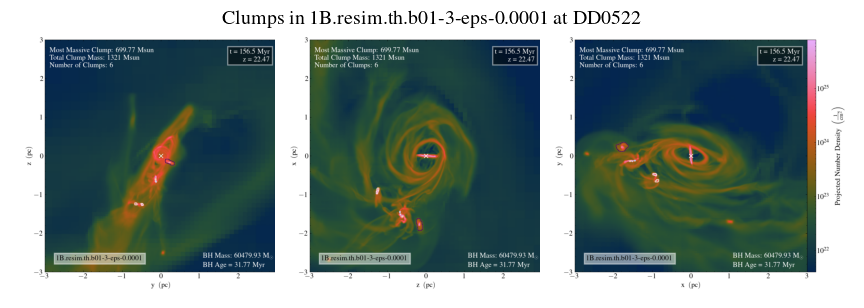

In [16]:
# BH Age = 31.77 Myr
image_paths_1 = ['../plots/clump_projection_1B.resim.th.b01-3-eps-0.0001_DD0522_0_1.00e+06_grav_bound.png',
                    '../plots/clump_projection_1B.resim.th.b01-3-eps-0.0001_DD0522_1_1.00e+06_grav_bound.png',
                    '../plots/clump_projection_1B.resim.th.b01-3-eps-0.0001_DD0522_2_1.00e+06_grav_bound.png']
make_3_panel_plot(image_paths_1)

# 1B.resim.th.b01-3-eps-0.001

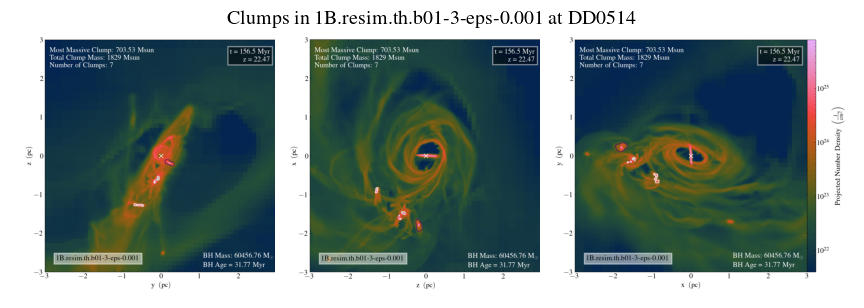

In [17]:
image_paths_2 = ['../plots/clump_projection_1B.resim.th.b01-3-eps-0.001_DD0514_0_1.00e+06_grav_bound.png',
                    '../plots/clump_projection_1B.resim.th.b01-3-eps-0.001_DD0514_1_1.00e+06_grav_bound.png',
                    '../plots/clump_projection_1B.resim.th.b01-3-eps-0.001_DD0514_2_1.00e+06_grav_bound.png']
make_3_panel_plot(image_paths_2)

# 1B.resim.th.b01-3-eta-0.01

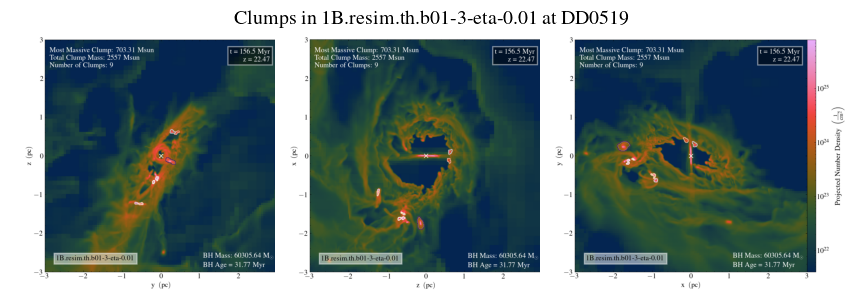

In [18]:
image_paths_3 = ['../plots/clump_projection_1B.resim.th.b01-3-eta-0.01_DD0519_0_1.00e+06_grav_bound.png',
                    '../plots/clump_projection_1B.resim.th.b01-3-eta-0.01_DD0519_1_1.00e+06_grav_bound.png',
                    '../plots/clump_projection_1B.resim.th.b01-3-eta-0.01_DD0519_2_1.00e+06_grav_bound.png']

make_3_panel_plot(image_paths_3)

# 1B.resim.th.b01-3-eta-0.1

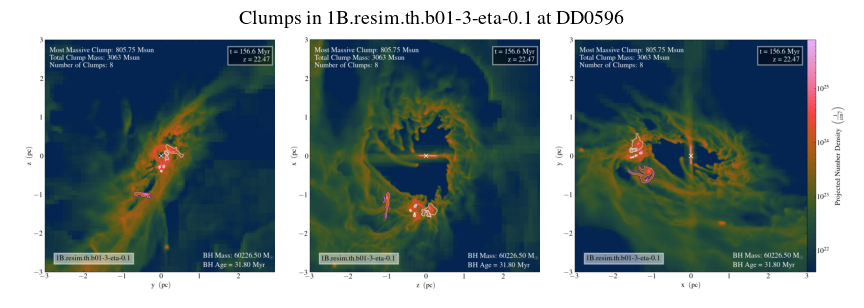

In [19]:
# image_paths_4 = ['../plots/clump_projection_1B.resim.th.b01-3-eta-0.1_DD0596_0_1.37e+03_grav_bound.png',
#                 '../plots/clump_projection_1B.resim.th.b01-3-eta-0.1_DD0596_1_1.37e+03_grav_bound.png',
#                 '../plots/clump_projection_1B.resim.th.b01-3-eta-0.1_DD0596_2_1.37e+03_grav_bound.png']
image_paths_4 = ['../plots/clump_projection_1B.resim.th.b01-3-eta-0.1_DD0596_0_1.00e+06_grav_bound.png',
                 '../plots/clump_projection_1B.resim.th.b01-3-eta-0.1_DD0596_1_1.00e+06_grav_bound.png',
                '../plots/clump_projection_1B.resim.th.b01-3-eta-0.1_DD0596_2_1.00e+06_grav_bound.png']

make_3_panel_plot(image_paths_4)

# Analysing Clumps

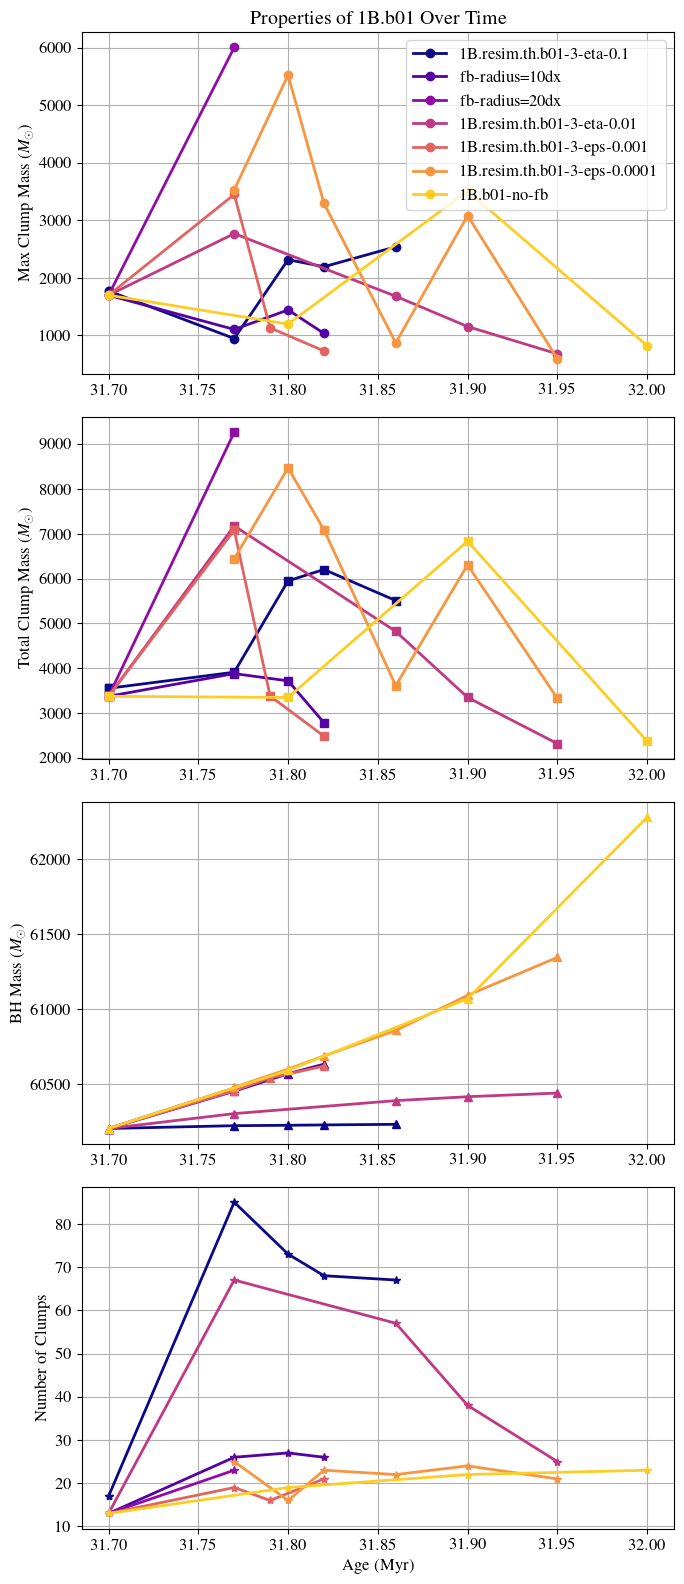

In [26]:
# Load the data from the CSV file
df = pd.read_csv('clump_data.csv', comment='#')  # Replace 'your_data.csv' with your actual file path

# Apply filters to dataframe (optional)
df['future_bound'] = df['future_bound'].map({' True': True, ' False': False})
df = df.round({'age_myr': 2, 'max_clump_mass': 1, 'total_clump_mass': 1, 'bh_mass':1, 'no_clumps': 0})
filt = df[df['future_bound'] == True]  # Keep only future bound clumps
filt = filt[filt['min_density'] == '597550.0448162535']

# Sort the DataFrame by 'age_myr' to ensure the plots are in chronological order
filt = filt.sort_values('age_myr')

# Unique simulations and BH Age values for grouping
# Replace "1B.RSb01-2" with "1B.b01-no-fb"
filt['simulation'] = filt['simulation'].replace("1B.RSb01-2", "1B.b01-no-fb")
simulations = filt['simulation'].unique()
# Define a custom order for the simulations
custom_order = ['1B.resim.th.b01-3-eta-0.1', '1B.resim.th.b01-3-eta-0.01', 'fb-radius=10dx', 'fb-radius=20dx',
                '1B.resim.th.b01-3-eps-0.001', '1B.resim.th.b01-3-eps-0.0001', '1B.b01-no-fb']  # Replace with your desired order

# Ensure that the custom order includes all simulations
if set(custom_order) != set(simulations):
    raise ValueError("Custom order must include all simulations")

simulations = custom_order
ages = filt['age_myr'].unique()
properties = ["max_clump_mass", "total_clump_mass", "bh_mass", "no_clumps"]

# Generate a color for each simulation using the colormap
color_map = plt.cm.plasma
colors = color_map(np.linspace(0, 0.90, len(simulations)))
simulation_colors = {simulation: color for simulation, color in zip(simulations, colors)}

# Create subplots - one for each property
fig, axs = plt.subplots(len(properties), 1, figsize=(7, 4 * len(properties)))

# Create a dictionary to store whether the legend label has been added for each simulation
added_legend = {simulation: False for simulation in simulations}

# Iterate over properties to create each subplot
for i, property in enumerate(properties):
    # Iterate over simulations
    for simulation in simulations:
        # Filter the data for each simulation
        data = filt[filt['simulation'] == simulation]
        # Get the color for the current simulation
        color = simulation_colors[simulation]
        # Check if there is data to plot
        if not data.empty:
            # Plot the data for the current simulation with markers and lines
            marker = 'o' if i == 0 else 's' if i == 1 else '^' if i == 2 else '*'
            axs[i].plot(data['age_myr'], data[property], marker=marker, linestyle='-', color=color, label=simulation if not added_legend[simulation] else "_nolegend_")
            # Add the simulation to the legend only if it hasn't been added before
            if not added_legend[simulation]:
                added_legend[simulation] = True


# Plot max_clump_mass over age_myr
axs[0].set_ylabel('Max Clump Mass ($M_\odot$)')
axs[0].set_title('Properties of 1B.b01 Over Time')
axs[0].legend()

# Plot total_clump_mass over age_myr
axs[1].set_ylabel('Total Clump Mass ($M_\odot$)')

# Plot bh_mass over age_myr
axs[2].set_ylabel('BH Mass ($M_\odot$)')

# Plot no_clumps over age_myr
axs[3].set_ylabel('Number of Clumps')
axs[-1].set_xlabel('Age (Myr)')

# Optional: Add grid to each subplot for better readability
for ax in axs:
    ax.grid(True)

plt.tight_layout()
plt.show()
print("")


In [24]:
simulations

array(['1B.resim.th.b01-3-eta-0.1', '1B.resim.th.b01-3-eta-0.01',
       '1B.resim.th.b01-3-eps-0.001', 'fb-radius=10dx', 'fb-radius=20dx',
       '1B.b01-no-fb', '1B.resim.th.b01-3-eps-0.0001'], dtype=object)

In [23]:
timestamp = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M")
figtitle = 'clump_properties_over_time' + f"_{simulations[0]}" + f"_{timestamp}"
plt.savefig(f'plots/{figtitle}.png', dpi=300, bbox_inches='tight')
print(f"Saved plot to plots/{figtitle}.png")

Saved plot to plots/clump_properties_over_time_1B.resim.th.b01-3-eta-0.1_2024-06-13-10-00.png


<Figure size 640x480 with 0 Axes>

# Residual Density Sliceplot

In [57]:
# Load the datasets
ds_og = yt.load("/Backup01/sgordon/disk14/pleiades-11-12-23/seed1-bh-only/270msun/replicating-beckmann/1B.RSb01-2/DD0445/DD0445")
ds_no_feedback = yt.load("/Backup01/sgordon/disk14/pleiades-11-12-23/seed1-bh-only/270msun/replicating-beckmann/1B.RSb01-2/DD0447/DD0447")
ds_with_feedback = yt.load("/disk01/sgordon/pleiades-18-03-24/seed1-bh-only/270msun/thermal-fb/1B.resim.th.b01-3-eta-0.1/DD0695/DD0695")
ss_pos_no_fb, ss_mass, ss_age = ss_properties(ds_no_feedback)
ss_pos_fb, _, _ = ss_properties(ds_with_feedback)
ss_pos_og, _, _ = ss_properties(ds_og)


yt : [INFO     ] 2024-06-12 19:51:32,945 Parameters: current_time              = 17.475156649306
yt : [INFO     ] 2024-06-12 19:51:32,947 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-06-12 19:51:32,948 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-06-12 19:51:32,949 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-06-12 19:51:32,950 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-06-12 19:51:32,951 Parameters: current_redshift          = 22.479904727113
yt : [INFO     ] 2024-06-12 19:51:32,952 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2024-06-12 19:51:32,953 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2024-06-12 19:51:32,954 Parameters: omega_radiation           = 0
yt : [INFO     ] 2024-06-12 19:51:32,956 Parameters: hubble_constant           = 0.71
yt : [INFO     ] 2024-06-12 19:51:33,094 Parameters: current_time              = 17.497494729306
yt :

ds =  DD0447


Parsing Hierarchy : 100%|██████████| 3826/3826 [00:00<00:00, 5835.45it/s]
yt : [INFO     ] 2024-06-12 19:51:34,073 Gathering a field list (this may take a moment.)


ds =  DD0695


Parsing Hierarchy : 100%|██████████| 5465/5465 [00:00<00:00, 7428.04it/s] 


ds =  DD0445


Parsing Hierarchy : 100%|██████████| 4002/4002 [00:00<00:00, 5107.48it/s]


In [58]:
#ss_age_no_fb = ss_age 

In [59]:
_, _, ss_age = ss_properties(ds_with_feedback)
ss_age_fb = ss_age

ds =  DD0695


In [61]:
global CONTRAST
CONTRAST = False

# Define the size of the region to visualize and the resolution of the FRB
width = (7.0, 'pc')  # Width of the region in physical units
resolution = (1000, 1000)  # Resolution of the FRB

# Load clump datasets (assuming these are the paths to your clump data files)
clumps_no_feedback = yt.load('../clumps/DD0447_clump_0.h5')
clumps_with_feedback = yt.load('../clumps/DD0695_clump_0.h5')
clumps_og = yt.load('../clumps/DD0445_clump_0.h5')

# Clump position (proper pc)
clumps_pos_no_fb = [clump["clump", "position"].to('pc') for clump in clumps_no_feedback.leaves]
clumps_pos_with_fb = [clump["clump", "position"].to('pc') for clump in clumps_with_feedback.leaves]
clumps_pos_og = [clump["clump", "position"].to('pc') for clump in clumps_og.leaves]

# Extract the position of the clumps relative to the BH
clumps_pos_rel_no_fb = np.array([pos - ss_pos_no_fb.to('pc') for pos in clumps_pos_no_fb])
clumps_pos_rel_with_fb = np.array([pos - ss_pos_fb.to('pc') for pos in clumps_pos_with_fb])
clumps_pos_rel_og = np.array([pos - ss_pos_og.to('pc') for pos in clumps_pos_og])


# Find position of most massive clump
pos_max_clump_no_fb = clumps_pos_no_fb[np.argmax([clump["clump", "cell_mass"].to('Msun') for clump in clumps_no_feedback.leaves])]
pos_max_clump_with_fb = clumps_pos_with_fb[np.argmax([clump["clump", "cell_mass"].to('Msun') for clump in clumps_with_feedback.leaves])]

yt : [INFO     ] 2024-06-12 19:56:19,815 Parameters: current_time              = 17.497494729306 code_time
yt : [INFO     ] 2024-06-12 19:56:19,816 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-06-12 19:56:19,817 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2024-06-12 19:56:19,818 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2024-06-12 19:56:19,819 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-06-12 19:56:19,820 Parameters: current_redshift          = 22.459915411172
yt : [INFO     ] 2024-06-12 19:56:19,821 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2024-06-12 19:56:19,822 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2024-06-12 19:56:19,823 Parameters: hubble_constant           = 0.71
yt : [WARNING  ] 2024-06-12 19:56:19,824 Geometric data selection not available for this dataset type.
yt : [INFO     ] 2024-06-12 19:56:20,228 Parame

In [62]:
# Create slices at the z-coordinate of the most massive clump in the no-feedback and with-feedback datasets
slice_no_feedback = ds_no_feedback.slice('z', pos_max_clump_no_fb[2])
slice_with_feedback = ds_with_feedback.slice('z', pos_max_clump_no_fb[2])

# Create FRBs of the slices centred on the BH position
frb_no_feedback = slice_no_feedback.to_frb(width, resolution, center=ss_pos_no_fb)
frb_with_feedback = slice_with_feedback.to_frb(width, resolution, center=ss_pos_no_fb)

In [63]:
# Calculate the residual density using FRBs
residual_density = np.array(frb_with_feedback['gas', 'density']) - np.array(frb_no_feedback['gas', 'density'])
#residual_density = np.array(frb_with_feedback['gas', 'density'])
residual_density.max(), residual_density.min()

yt : [INFO     ] 2024-06-12 19:56:25,969 Making a fixed resolution buffer of (('gas', 'density')) 1000 by 1000


(3.3375273626823443e-17, -1.1791056581256933e-16)

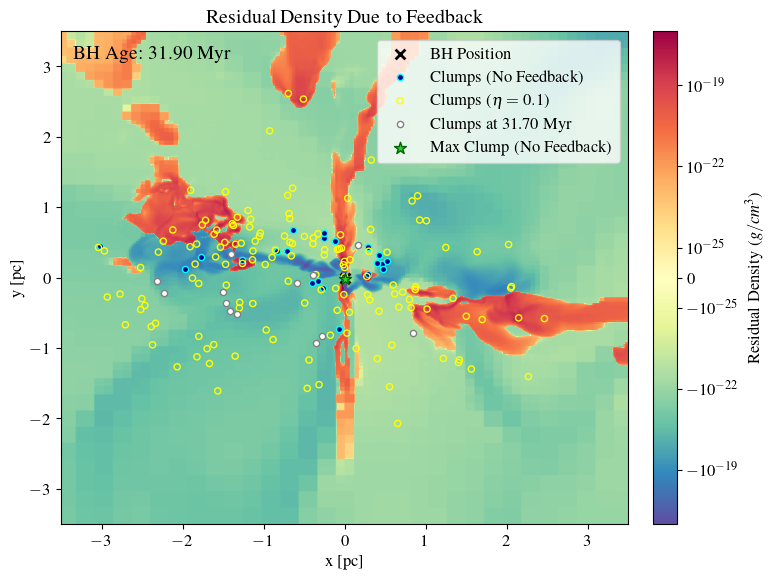

In [65]:
# Plotting the residual density FRB
plt.figure(figsize=(8, 6.4))

extent = [-width[0]/2, width[0]/2, -width[0]/2, width[0]/2]  # Centering the plot around ss_pos

# Select a random clump position as the new center for the plot
np.random.seed(42)  # For reproducibility, optional
random_clump_index = np.random.randint(0, len(clumps_pos_rel_no_fb))
random_clump_pos = clumps_pos_rel_no_fb[random_clump_index]

# Define the size of the region to visualize around the selected clump
width_clump = (1.0, 'pc')  # Smaller width for zooming in
resolution_clump = (1000, 1000)  # Resolution of the FRB, adjust as needed

# Calculate the extent around this clump
extent_clump = [
    random_clump_pos[0] - width_clump[0]/2, random_clump_pos[0] + width_clump[0]/2,
    random_clump_pos[1] - width_clump[0]/2, random_clump_pos[1] + width_clump[0]/2
]

# Set the norm to LogNorm to apply a logarithmic scale
# Adjust vmin and vmax as needed; these should be > 0 for log scale
vmin, vmax, linthresh = -1e-17, 1e-17, 1e-25
im = plt.imshow(
    residual_density if not CONTRAST else density_contrast,
    extent=extent, # Change extent to zoom in on the clump
    origin='lower',
    aspect='auto',
    cmap='Spectral_r',
    norm=SymLogNorm(linthresh=linthresh, vmin=vmin, vmax=vmax, base=10),
)

# Mark ss_pos on the plot (center of the plot in this case)
plt.scatter(0, 0, color='black', marker='x', s=50, label='BH Position')

# Overplot the time text on the top left corner
time_text = f"BH Age: {ss_age_fb[0]/1e6:.2f} Myr"
plt.text(
    0.02, 0.97,  # x, y in figure coordinates
    time_text,
    transform=plt.gca().transAxes,  # Use axis transform to interpret coordinates
    fontsize=14,
    color='black',  # Choose a color that stands out against your plot background
    ha='left',  # Horizontal alignment
    va='top'    # Vertical alignment
)

# Overlay clump positions for the no-feedback dataset
msize = 20
plt.scatter(
    clumps_pos_rel_no_fb[:, 0],  # X positions
    clumps_pos_rel_no_fb[:, 1],  # Y positions
    color='darkblue', marker='o', s=msize, edgecolors='cyan', label='Clumps (No Feedback)'
)

# Overlay clump positions for the with-feedback dataset
plt.scatter(
    clumps_pos_rel_with_fb[:, 0],  # X positions
    clumps_pos_rel_with_fb[:, 1],  # Y positions
    color='yellow', marker='o', s=msize, facecolors='none', label=r'Clumps ($\eta=0.1$)'
)

# Overlay clump positions for the original dataset
plt.scatter(
    clumps_pos_rel_og[:, 0],  # X positions
    clumps_pos_rel_og[:, 1],  # Y positions
    color='white', marker='o', s=msize, edgecolors='grey', label='Clumps at 31.70 Myr'
)

# Overlay the position of the most massive clump in no-fb
plt.scatter(
    pos_max_clump_no_fb[0] - ss_pos_no_fb[0].to('pc'),  # X positions
    pos_max_clump_no_fb[1] - ss_pos_no_fb[1].to('pc'),  # Y positions
    color='limegreen', marker='*', s=msize*4, edgecolors='darkgreen', 
    label='Max Clump (No Feedback)'
)

# # Setting tick locations and labels relative to ss_pos
# tick_locs = np.linspace(-width[0]/2, width[0]/2, num=5)  # Example: 5 ticks from -width/2 to width/2
# tick_labels = [f"{loc:.1f}" for loc in tick_locs]  # Convert tick locations to labels
# plt.xticks(tick_locs, tick_labels)
# plt.yticks(tick_locs, tick_labels)

cbar = plt.colorbar(im, label=r'Density Contrast', fraction=0.046, pad=0.04) if CONTRAST else plt.colorbar(im, label=r'Residual Density ($g/cm^3$)', fraction=0.046, pad=0.04)
plt.xlabel('x [pc]')
plt.ylabel('y [pc]')
plt.title('Density Contrast Due to Feedback') if CONTRAST else plt.title('Residual Density Due to Feedback')
plt.legend(loc='upper right')
plt.show()

clump["clump", "position"].to('pc') - ss_pos_fb.to('pc')

In [69]:
timestamp = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M")
figtitle = 'clump_residual_density_projection+clumps' + f"_{timestamp}"
plt.savefig(f'plots/{figtitle}.png', dpi=300, bbox_inches='tight')
print(f"Saved plot to plots/{figtitle}.png")

Saved plot to plots/clump_residual_density_projection+clumps_2024-06-12-20-12.png


<Figure size 640x480 with 0 Axes>

In [133]:
# # Plot the density slice for the no-feedback run
# p1 = yt.SlicePlot(ds_no_feedback, 'x', 'density', center=ss_pos_no_fb, width=(7.0, 'pc'))
# p1.set_cmap(field='density', cmap='viridis')
# p1.annotate_marker(ss_pos_no_fb, marker='x', plot_args={'color': 'red'})
# p1.show()

# # Plot the density slice for the feedback run
# p2 = yt.SlicePlot(ds_with_feedback, 'x', 'density', center=ss_pos_fb, width=(7.0, 'pc'))
# p2.set_cmap(field='density', cmap='viridis')
# p2.annotate_marker(ss_pos_fb, marker='x', plot_args={'color': 'red'})
# p2.show()

# Tree Plot of Clumps

In [ ]:
from fragplot import TreePlot

CLUMP_FILE_NAME = "'../DD0446_clump_0.h5"
TREE_NAME = "clump_tree_no_fb_446_test.png"

def my_node(clump):
    """
    Customise the appearance of the nodes in the tree plot
    """
    child_clumps = clump.children
    if (child_clumps is None):
        label = ''
    else :
        density = clump[('clump', 'min_number_density')].to('cm**(-3)').value
        label = f'{density:.3g}'

    if (clump[('clump', 'fragmentation_instability')] > 1.0):
        shape = 'square'
    else :
        shape = 'circle'
    my_kwargs = {'label': label, 'fontsize': 16, 'shape': shape}
    return my_kwargs

def create_tree_plot(ds):
    """
    Create a tree plot of the clump hierarchy
    """
    p = TreePlot(ds, dot_kwargs={'rankdir': 'TB', 'size': 18}, node_function= my_node)
    p.size_field = "mass"
    p.color_field = "max_metallicity"
    p.node_cmap = 'turbo'
    p.save(TREE_NAME)


In [ ]:
ds = yt.load(CLUMP_FILE_NAME)
create_tree_plot(df)